# Program Header

In [105]:
import pandas as pd
import numpy as np
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from header import *

In [106]:
data_root = initialize_data_root("AY")

In [107]:
from sklearn import model_selection, metrics, ensemble

import seaborn as sn
import matplotlib.pyplot as plt

# Import

In [108]:
raw_data = pd.read_csv(data_root + '02-build/clean/2019q3/2019q3merged.csv')

# Clean

In [125]:
data = raw_data.drop('Unnamed: 0', axis = 'columns')\
    .assign(clean_shares = raw_data[['WeightedAverageNumberOfDilutedSharesOutstanding',
       'WeightedAverageNumberOfSharesOutstandingBasic']].max(axis = 'columns'))\
    .drop(['WeightedAverageNumberOfDilutedSharesOutstanding',
       'WeightedAverageNumberOfSharesOutstandingBasic'], axis = 'columns')

data['market_cap'] = data['7_after'] * data['clean_shares']
data = data.loc[data['market_cap'] > 0,:]
data['market_cap_deciles'] = pd.qcut(data['market_cap'], q = 10, labels = range(10))

In [197]:
print((pd.DataFrame(data.market_cap.describe())/1000000).round())
print()
print("Figures in millions")

       market_cap
count         0.0
mean       7548.0
std       38861.0
min           0.0
25%         119.0
50%         721.0
75%        3320.0
max     1067083.0

Figures in millions


In [127]:
X = data.loc[:,'AccountsPayableCurrent':'TreasuryStockValue']
Y_price_deciles = data['market_cap_deciles']
Y_price_change = data['per']

# Modeling

### Split into training and test sets

In [128]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X,Y_price_deciles, test_size = 0.30)

### Random Forest Classifier

In [129]:
rf = ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'entropy', oob_score = True)
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [130]:
rf.oob_score_

0.4504657070279424

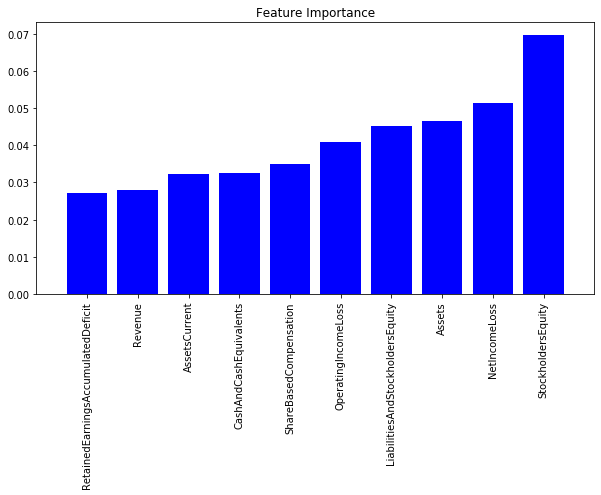

In [131]:
importance = rf.feature_importances_
indices = np.argsort(importance)

plt.figure(figsize=(10,5))
plt.title("Feature Importance")
plt.bar(X_train.columns[indices][- 10:], importance[indices][- 10:], 
        color = 'b', align = 'center')
plt.xticks(range(10), X.columns[indices][-10:], rotation = 90)
plt.xlim([-1, 10])
plt.show()

In [132]:
Y_pred = rf.predict(X_test)

### Evaluation

We use three evaluation metrics:
1. Accuracy
2. Absolute mean-squared difference in classification
3. Visual check on confusion matrix

In [210]:
# Accuracy
accuracy = np.round(sum(Y_pred == Y_test)/len(Y_test), 3) * 100

In [213]:
# Absolute mean error
abs_mean_error = np.round(np.mean(np.abs(np.subtract(Y_pred, np.array(Y_test)))), 3)

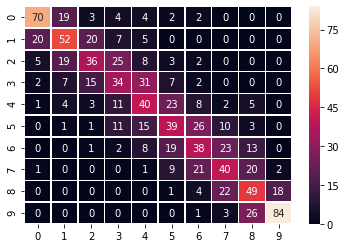

Accuracy: 47.60%
Absolute Mean Error: 0.76


In [217]:
# Heatmap of confusion matrix
heatmap = sn.heatmap(metrics.confusion_matrix(Y_test, Y_pred), annot=True, linewidths=.5)
# fix for mpl bug that cuts off top/bottom of seaborn viz using code from quora
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()
print("Accuracy: %.2f%%" %accuracy)
print("Absolute Mean Error: %.2f" %abs_mean_error)